In [ ]:
%%capture
!pip install super-gradients
!pip install imutils
!pip install roboflow

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.processing import ComposeProcessing, DetectionRescale, DetectionCenterPadding, StandardizeImage, ImagePermute

from super_gradients.training import models

The console stream is logged into /root/sg_logs/console.log


[2024-03-05 00:23:57] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-03-05 00:23:58] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-05 00:23:58] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-03-05 00:24:16] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-05 00:24:16] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-05 00:24:16] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-03-05 00:24:16] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-03-05 00:24:16] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-03-05 00:24:16] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2024-03-05 00:24:16] WARNING - env_sanity_check.py - 

In [ ]:
# Create checkpoint directory and initialize trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='ppe_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
from roboflow import Roboflow

# Download Roboflow dataset
api_key = os.getenv('ROBOFLOW_KEY')
rf = Roboflow(api_key=api_key)
project = rf.workspace("project-uyrxf").project("ppe_detection-v1x3l")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.


Extracting Dataset Version Zip to PPE_Detection-2 in yolov8::  89%|████████▉ | 5757/6472 [00:03<00:00, 1820.85it/s]

In [ ]:
# Define object classes
classes = ['Dust Mask', 'Eye Wear', 'Glove', 'Protective Boots', 'Protective Helmet', 'Safety Vest', 'Shield']

# Define image transformation methods
train_transforms = [
    {'DetectionMosaic': {'input_dim': [640, 640], 'prob': 1.0}},
    {'DetectionRandomAffine':
        {
            'degrees': 10.0,
            'translate': 0.1,
            'scales': [0.3, 2],
            'shear': 2.0,
            'target_size': [640, 640],
            'filter_box_candidates': True,
            'wh_thr': 2,
            'area_thr': 0.1,
            'ar_thr': 20,

        }
    },
    {'DetectionMixup':
     {
        'input_dim': [640, 640],
        'mixup_scale': [0.5, 1.5],
        'prob':0.5,
        'enable_mixup': True,
        'flip_prob': 0.5,
        'border_value': 114
        }
     },
    {'DetectionHSV': {'prob': 0.5, 'hgain': 0.5, 'sgain': 0.5, 'vgain': 0.5}},
    {'Albumentations': {
        'Compose': {
            'transforms': [{'ImageCompression': {'quality_lower': 75, 'p': 0.1}}, {'Blur': {'p': 0.2}}, {'Perspective': {'p': 0.5}}],
            "bbox_params": {"min_area": 1, "min_visibility": 0, "min_width": 0, "min_height": 0, "check_each_transform": True},
        }
    }},
    {'DetectionHorizontalFlip': {'prob': 0.5}},
    {'DetectionPaddedRescale': {'input_dim': [640, 640]}},
    {'DetectionTargetsFormatTransform':
        {
            'input_dim': [640, 640],
            'output_format': 'LABEL_CXCYWH'
        }
    }
]

# Define parameters for train, val, and test dataset objects

train_dataset_params = {
    'data_dir':'/content/PPE_Detection-2',
    'images_dir':'train/images',
    'labels_dir':'train/labels',
    'transforms': train_transforms,
    'classes': classes
}

val_dataset_params = {
    'data_dir':'/content/PPE_Detection-2',
    'images_dir':'valid/images',
    'labels_dir':'valid/labels',
    'classes': classes
}

test_dataset_params = {
    'data_dir':'/content/PPE_Detection-2',
    'images_dir':'test/images',
    'labels_dir':'test/labels',
    'classes': classes
}

dataloader_params = {
    'batch_size':16,
    'num_workers':2
}


In [ ]:
# Create train, val, and test data in COCO YOLO format

train_data = coco_detection_yolo_format_train(
    dataset_params=train_dataset_params,
    dataloader_params=dataloader_params
)

val_data = coco_detection_yolo_format_val(
    dataset_params=val_dataset_params,
    dataloader_params=dataloader_params
)

test_data = coco_detection_yolo_format_val(
    dataset_params=test_dataset_params,
    dataloader_params=dataloader_params
)

[2024-03-04 13:32:37] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2271/2271 [00:00<00:00, 2894.74it/s]
[2024-03-04 13:32:38] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 637/637 [00:00<00:00, 2877.32it/s]
[2024-03-04 13:32:38] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


Indexing dataset annotations: 100%|██████████| 322/322 [00:00<00:00, 2963.33it/s]


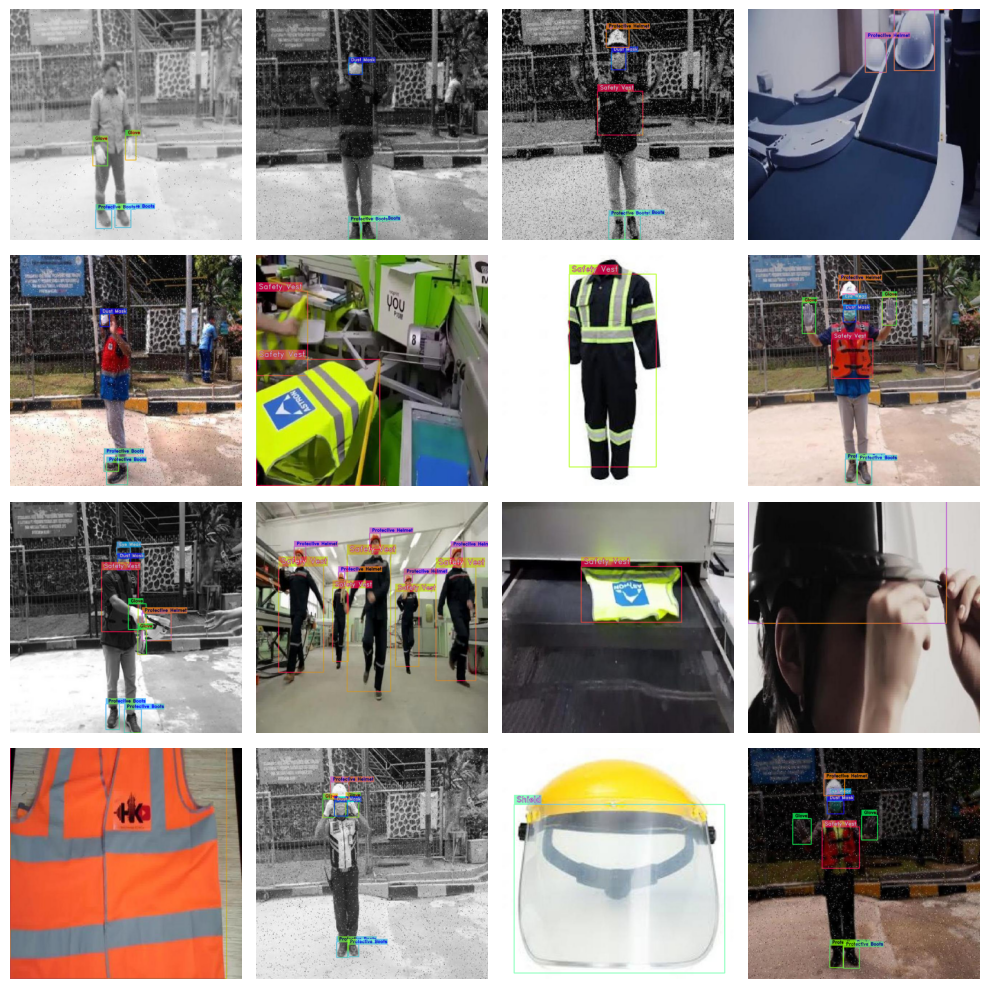

In [ ]:
# Images before augmentation

train_data.dataset.plot(plot_transformed_data=False)

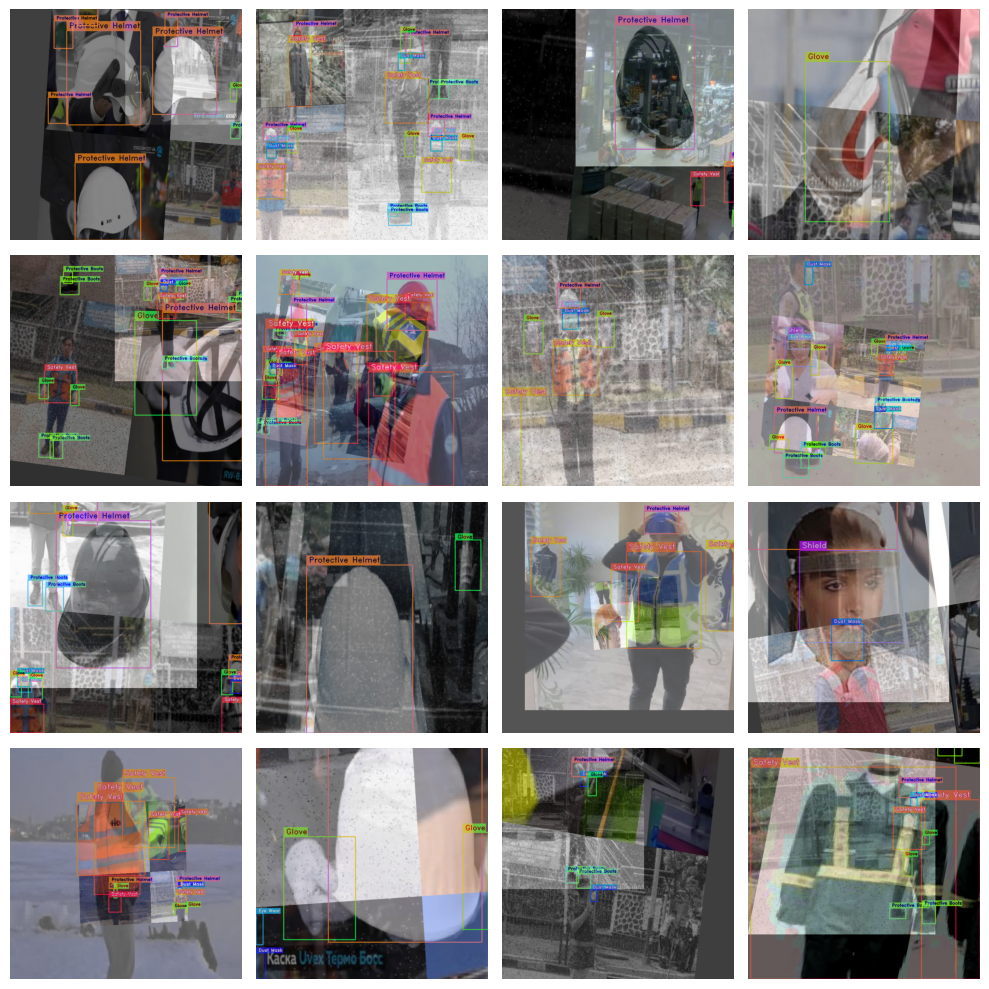

In [ ]:
# Images after augmentation

train_data.dataset.plot()

In [ ]:
# Get COCO-pretrained YOLO-NAS-M model
model = models.get('yolo_nas_m',
                   num_classes=len(classes),
                   pretrained_weights="coco")

[2024-03-05 00:29:52] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:08<00:00, 24.4MB/s]
[2024-03-05 00:30:01] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


In [ ]:
# Define train parameters
train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(classes),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(classes),
            normalize_targets=True,
            include_classwise_ap=True,
            calc_best_score_thresholds=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

[2024-03-04 12:07:47] WARNING - detection_metrics.py - Parameter 'include_classwise_ap' is set to True, but no class names are provided. We will generate dummy class names, but we recommend to provide class names explicitly tohave meaningful names in reported metrics.


In [ ]:
# Train the model
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

In [ ]:
from google.colab import drive
import locale

drive.mount('/content/drive')
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!mv /content/checkpoints/ppe_yolonas_run/RUN_20240303_052646_413140 /content/drive/MyDrive/Synapsis/

In [ ]:
# Load the best model from the training
best_model = models.get('yolo_nas_m',
                        num_classes=len(classes),
                        checkpoint_path="/content/drive/MyDrive/Synapsis/RUN_20240303_052646_413140/ckpt_best.pth")

[2024-03-05 00:31:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Synapsis/RUN_20240303_052646_413140/ckpt_best.pth EMA checkpoint.


In [ ]:
# Test the model on the test dataset
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(classes),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)))

Testing: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


{'Precision@0.50': 0.1770370453596115,
 'Recall@0.50': 0.9740196466445923,
 'mAP@0.50': 0.8739213943481445,
 'F1@0.50': 0.2853551208972931,
 'Best_score_threshold': 0.4399999976158142}

In [ ]:
input_video_path = "/content/drive/MyDrive/Synapsis/video.mov"
output_video_path = "/content/drive/MyDrive/Synapsis/video-result.mov"

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else "cpu"
result = best_model.to(device).predict(input_video_path, conf=0.44, iou=0.5)
result.save(output_video_path)

Processing Video:  99%|█████████▉| 3453/3473 [04:35<00:00, 24.93it/s]

[2024-03-05 00:34:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


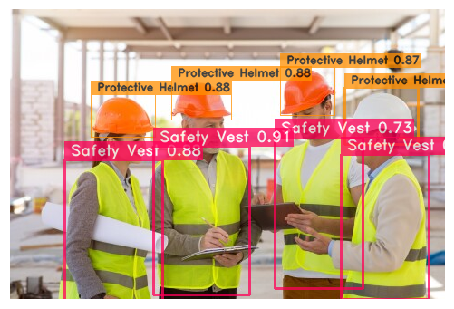

In [ ]:
result = best_model.to(device).predict('labor.png', conf=0.44, iou=0.5)
result.show()